#***Image reconstruction with Autoencoders***

An autoencoder is a neural network model consisting of two inverse but interconnected multilayer perceptrons attempting to reconstruct the given input according to the described target. They are primarily used for dimensionality reduction, but can also prove useful in denoising and colorizing images.

* **name**: Asimakis Kydros
* **srn**: 3881
* **email**: asimakis@csd.auth.gr

In [ ]:
import numpy as np
import time
import pandas as pd
import pickle
import os
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from keras.datasets import mnist
import matplotlib.pyplot as plt
from ipywidgets import interact, widgets
from IPython.display import display, clear_output
from itertools import product

DIM = 28 * 28

##**Building the input**

What an autoencoder reconstructs heavily relies on the target given. To better create target sets, we are going to need the following aid-functions.

In [ ]:
def arr_sort(*args):
    ''' Sorts the given arrays based on label and in such a way that
        the mapping x_i -> y_i is preserved. Pass the labels first.
    '''
    if len(args) < 1:
        raise ValueError('No parameters passed.')
    if len(set([arr.shape[0] for arr in args])) > 1:
        raise ValueError('All input arrays must be of the same size.')
    if args[0].shape[1] > 1:
        raise ValueError('Pass the label array first.')

    i_sort = np.argsort(args[0], axis=None)
    return tuple(arr[i_sort] for arr in args)

In [ ]:
def arr_shuffle(*args):
    ''' Shuffles the given array(s) in a random fashion. Tuples of
        arrays preserve the x_i -> y_i -> z_i ... mapping.
    '''
    if len(args) < 1:
        raise ValueError('No parameters passed.')
    if len(set([arr.shape[0] for arr in args])) > 1:
        raise ValueError('All input arrays must be of the same size.')

    i_shuffle = np.random.permutation(args[0].shape[0])
    return tuple(arr[i_shuffle] for arr in args)

##**Finding the best Oracle**

Measuring the accuracy of such a model is a tricky case; Checking for 1:1 similarity for every pixel is bound to give abyssmal results every time, as
the autoencoder will learn to map every new image to the *average* of the image it learns as correct (therefore, next to no pixels will actually be copied exactly to the output).

One way to simulate accuracy measurement is to use an Oracle, in this case here an MLP that is trained to recognize the image-set.

Of course, such an oracle has to be as close to perfect at its job as possible to ensure maximum objectiveness on the final score.

In [ ]:
(x_tr, y_tr), (_, _) = mnist.load_data
x_tr, y_tr = x_tr.reshape(-1, DIM), y_tr.reshape(-1, 1)

grid_search = GridSearchCV(
    MLPClassifier(random_state=42),
    {'hidden_layer_sizes': [(100,), (200,), (200, 100)],
     'activation': ['tanh', 'relu'],
     'alpha': [0.01, 0.001, 0.0001],
     'batch_size': ['auto', 300, 500],
     'early_stopping': [True, False],
     },
    cv=3, n_jobs=-1
)
grid_search.fit(x_tr, y_tr.ravel())
print(f'Best parameters: {grid_search.best_params_}')

    I tried to run this here and Google Colab stopped my runtime overnight.
    I ran it on my own system with more cores and got the following, but
    you'll have to trust me :) .

    Best parameters: {'activation'        : 'relu',
                      'alpha'             : 0.001,
                      'batch_size'        : 'auto',
                      'early_stopping'    : False,
                      'hidden_layer_sizes': (200, 100)}

##**Autoencoder with MLPRegressor**

A typical autoencoder uses an MLP to reduce the given input into the bottleneck (encoding part) and then another MLP with mirrored layer sizes to predict back the input from the bottleneck. I tried to code this and failed miserably!

Instead, according to [this source](https://github.com/scikit-learn/scikit-learn/issues/25216), an MLPRegressor can approximate the function of an autoencoder with a single layer. This makes sense, as the regressor will output as many values as the given target set length (therefore passing mlpr(b).fit(X, X) actually creates a (len(X), b, len(X)) network with mirrored encoder-decoder sizes).

Obviously this approach is very limiting, but it ensures that the model works as best as possible.

In [ ]:
class Autoencoder:
    def __init__(self, dim: int, oracle = None):
        self.shape = (dim,)
        self.coder = None
        self.oracle = oracle if oracle is not None else MLPClassifier((200, 100), alpha=0.001, random_state=42)

    def fit(self, x: np.ndarray, t: np.ndarray, y: np.ndarray = None):
        if y is not None:
            self.oracle.fit(x, y.ravel())
        self.coder = MLPRegressor(
            hidden_layer_sizes=self.shape,
            activation='identity',
            random_state=42
            )
        self.coder.fit(x, t)
        return self

    def reconstruct(self, x: np.ndarray):
        return self.coder.predict(x)

    def score(self, x: np.ndarray, l: np.ndarray):
        t = self.reconstruct(x)
        return self.oracle.score(t, l)

To better visualize the output, this function here creates a small GUI of a carousel, that presents a different random original-reconstructed image pair with every click. The buttons **Next Correct** and **Next Error** have to do with what the *Oracle* believes, not the Autoencoder itself.

In [ ]:
# FUNCTION (MOSTLY) GENERATED BY CHATGPT
def GUI_display(images: np.ndarray, predicts: np.ndarray, y_true: np.ndarray, y_pred: np.ndarray, title: str):
    if len(images) != len(predicts) != len(y_true) != len(y_pred):
        print('Returned early, dimensionality mismatch encountered.')
        return
    # Create a function to display the original and reconstructed images
    def display_images(index, main_title):
        clear_output(wait=True)
        plt.figure(figsize=(8, 4))

        plt.subplot(1, 2, 1)
        plt.imshow(images[index], cmap='gray')
        plt.title(f'Original')
        plt.axis('off')

        plt.subplot(1, 2, 2)
        plt.imshow(predicts[index], cmap='gray')
        plt.title(f'Reconstruction')
        plt.axis('off')

        plt.suptitle(main_title)
        plt.show()

        # Display buttons
        display(widgets.HBox([next_pair_button, next_error_button]))

    # Function to handle button clicks
    def on_button_click(choice):
        if choice.description == 'Next Correct':
            # display_images(np.random.randint(len(images)))
            correct_label_indices = np.where(y_true == y_pred)[0]
            index = np.random.choice(correct_label_indices)
            display_images(index, title)
        elif choice.description == 'Next Error':
            wrong_label_indices = np.where(y_true != y_pred)[0]
            index = np.random.choice(wrong_label_indices)
            display_images(index, title)

    # Create buttons
    next_pair_button = widgets.Button(description='Next Correct')
    next_error_button = widgets.Button(description='Next Error')

    # Bind button clicks
    next_pair_button.on_click(on_button_click)
    next_error_button.on_click(on_button_click)

    # Display the initial pair
    display_images(np.random.randint(len(images)), title)

##**Test #1: Mod-10 Up-counter Autoencoder**

Let's start testing. We can simulate an adder by instructing the autoencoder to construct the next digit of what it sees. This effectively means creating a target set such that $x \rightarrow (x + 1) \text{ mod } 10$.

In [ ]:
# summon and reshape the raw data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train.reshape(-1, DIM), x_test.reshape(-1, DIM)
y_train, y_test = y_train.reshape(-1, 1), y_test.reshape(-1, 1)

# sort by digit to make creating the target set easier
y_train, x_train = arr_sort(y_train, x_train)
y_test, x_test = arr_sort(y_test, x_test)

# move the zeros to the end of the arrays so x_target[i] = (x_train[i] + 1) % 10
n_zeros = len(np.where(y_train == 0)[0])
x_target, y_target = np.roll(x_train, -n_zeros, axis=0), np.roll(y_train, -n_zeros, axis=0)
y_test = np.roll(y_test, -len(np.where(y_test == 0)[0]), axis=0)

# shuffle to preserve variance
x_train, y_train, x_target, y_target = arr_shuffle(x_train, y_train, x_target, y_target)
x_test, y_test = arr_shuffle(x_test, y_test)

In [ ]:
aec = Autoencoder(dim = 50)

t0 = time.time()
aec.fit(x_train, x_target, y_train)
t1 = time.time()

print(f'''
train score = {aec.score(x_train, y_target) * 100:.2f}%
 test score = {aec.score(x_test, y_test) * 100:.2f}%
   fit time = {t1 - t0:.4f} sec
''')

# PICKLE-ING THE RECONSTRUCTIONS SO YOU DONT HAVE TO RERUN THIS CELL

rec_imgs = aec.reconstruct(x_test).reshape((-1, 28, 28))
y_pred = aec.oracle.predict(rec_imgs.reshape(-1, DIM)).reshape(-1, 1)

with open(os.path.join('test1', 'aec_preds.pkl'), 'wb') as f:
    pickle.dump(rec_imgs, f)
with open(os.path.join('test1', 'aec_labels.pkl'), 'wb') as f:
    pickle.dump(y_pred, f)


train score = 43.73%
 test score = 43.97%
   fit time = 810.9619 sec



    Expected output of above code cell (ETA ~14mins):

    train score = 43.73%
     test score = 43.97%
       fit time = 810.9619 sec

The oracle 'underfits' (it actually doesn't, for both train and test what is sees is the reconstruction, and it was trained on the original images), but even then the scores aren't that bad; it can be shown below that the outputs are very very blurry, so an accuracy of 40% is better than expected. Fit time is acceptable for such a big drop in components, especially considering that a fair part of that time was spent in training the oracle, not the actual coder.

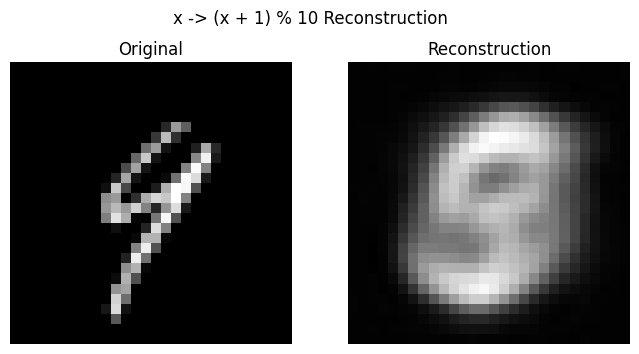

In [ ]:
# RUN THIS CELL WITH DIRECTORY 'TEST1' LOADED (ETA <1sec)

org_imgs = x_test.reshape((-1, 28, 28))
with open(os.path.join('test1', 'aec_preds.pkl'), 'rb') as f:
    rec_imgs = pickle.load(f)
with open(os.path.join('test1', 'aec_labels.pkl'), 'rb') as f:
    y_pred = pickle.load(f)

GUI_display(org_imgs, rec_imgs, y_test, y_pred, 'x -> (x + 1) % 10 Reconstruction')

Dropping the dimensionality to 50 definitely had an impact on the visual clarity, but still the autoencoder reconstructs correctly most of the time. The predicted images are very blob-y for the more round digits, which definately led the oracle in thinking it sees an eight, but we can see the correct digit emerge from the blurry blob with more intense pixels in the corresponding shape.

##**Test #2: Dimensionality Reduction comparison with PCA**

Another typical and more common way to perform dimensionality reduction is through PCA. The inverse transform that it applies can thus be used for reconstruction. We should compare the two approaches, by driving both to their limits; let's reduce the dimensions from 781 to 10.

In [ ]:
# for fairness and for the sake of having more samples, we are only going to
# use the train set
(x_train, y_train), (_, _) = mnist.load_data()

In [ ]:
# REDUCING WITH x -> x AUTOENCODER
aec1 = Autoencoder(dim=10).fit(x_train, x_train, y_train)
aec_recs = aec1.reconstruct(x_train).reshape((-1, 28, 28))
aec_labels = aec1.oracle.predict(aec_recs.reshape(-1, DIM)).reshape(-1, 1)

# REDUCING WITH PCA
pca = PCA(n_components=10, random_state=42)
pca_recs = pca.inverse_transform(pca.fit_transform(x_train)).reshape((-1, 28, 28))
pca_labels = aec1.oracle.predict(pca_recs.reshape(-1, DIM)).reshape(-1, 1)

# PICKLE-ING THE RECONSTRUCTIONS DO YOU DONT HAVE TO RERUN THIS CELL
with open(os.path.join('test2', 'aec_preds.pkl'), 'wb') as f:
    pickle.dump(aec_recs, f)
with open(os.path.join('test2', 'aec_labels.pkl'), 'wb') as f:
    pickle.dump(aec_labels, f)
with open(os.path.join('test2', 'pca_preds.pkl'), 'wb') as f:
    pickle.dump(pca_recs, f)
with open(os.path.join('test2', 'pca_labels.pkl'), 'wb') as f:
    pickle.dump(pca_labels, f)

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


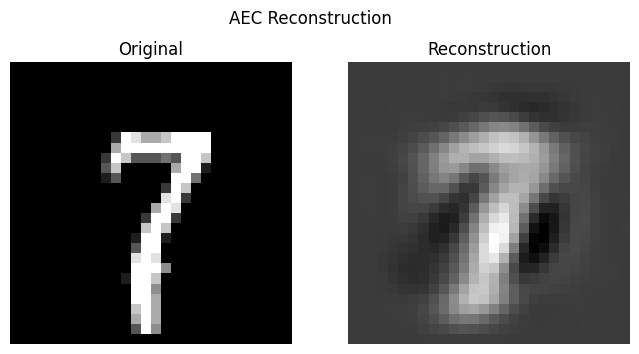

In [ ]:
# RUN THIS CELL WITH DIRECTORY 'TEST2' LOADED (ETA <1sec)
# AEC PART
org_imgs = x_train.reshape((-1, 28, 28))

with open(os.path.join('test2', 'aec_preds.pkl'), 'rb') as f:
    aec_recs = pickle.load(f)
with open(os.path.join('test2', 'aec_labels.pkl'), 'rb') as f:
    aec_labels = pickle.load(f)

GUI_display(org_imgs, aec_recs, y_train, aec_labels, 'AEC Reconstruction')

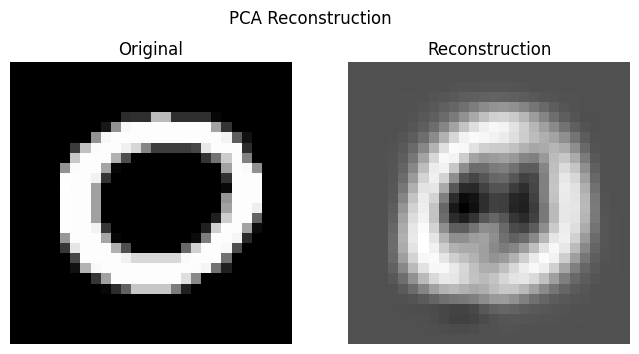

In [ ]:
# RUN THIS CELL WITH DIRECTORY 'TEST2' LOADED (ETA <1sec)
# PCA PART
with open(os.path.join('test2', 'pca_preds.pkl'), 'rb') as f:
    pca_recs = pickle.load(f)
with open(os.path.join('test2', 'pca_labels.pkl'), 'rb') as f:
    pca_labels = pickle.load(f)

GUI_display(org_imgs, pca_recs, y_train, pca_labels, 'PCA Reconstruction')

The autoencoder does not converge in the given iterations, but even still, the results from both seem fairly the same. PCA seems to be slightly better on average across all samples, while the Autoencoder reconstructs better shapes for some samples and worse for others.

10 dimensions is way overkill; both models barely paint black anymore. It is important to note that the autoencoder seems to prefer a darker side of gray for the background though.

##**Test #3: 2-digit Adder Autoencoder**

A more challenging version of test #1 is to turn the autoencoder into an adder, by feeding a mapping of $x1, x2 \rightarrow (x1 + x2)\text{ div } 10, (x1 + x2)\text{ mod } 10$. The way it was attempted here is that the input images were glued together vertically and then the autoencoder learned to produce glued pairs of images, that were in turn split to form the correct output.

To create the train-target set that was just described, we will need another aid-function:

In [ ]:
def arr_flatten(x, y):
    ''' Returns the given lists of tuples as numpy arrays with
        elements the concatenated sub-arrays for x and the sum
        of the labels for y.
    '''
    x_flattened = np.zeros((len(x), 2 * DIM))
    y_flattened = np.zeros((len(y), 1))

    for i, (x1, x2) in enumerate(x):
        x_flattened[i] += np.concatenate((x1, x2))
    for i, (y1, y2) in enumerate(y):
        y_flattened[i] += y1 + y2

    return x_flattened, y_flattened

Ideally, to be absolutely fair, we would need all cartesian pairs of the train set with itself for training. This of course would result in a ginormous matrix so it will not be attempted. A sample of $\frac{1}{200}$ from both the train and test sets will have to suffice.

In [ ]:
DIM = 28 * 28

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# keep a random 1/200th of the original dataset
(x_train, y_train), (x_test, y_test) = arr_shuffle(x_train, y_train), arr_shuffle(x_test, y_test)
x_train, y_train = x_train[:len(x_train) // 200].reshape(-1, DIM), y_train[:len(x_train) // 200].reshape(-1, 1)
x_test, y_test = x_test[:len(x_test) // 200].reshape(-1, DIM), y_test[:len(x_test) // 200].reshape(-1, 1)

# find all cartesian pairs and merge them
x_train, y_train = list(product(x_train, x_train)), list(product(y_train, y_train))
x_test, y_test = list(product(x_test, x_test)), list(product(y_test, y_test))
(x_train, y_train), (x_test, y_test) = arr_flatten(x_train, y_train), arr_flatten(x_test, y_test)

Creating the target set needs a little more thought and manual labor this time. **y_train** now describes the desired sum, therefore **x_target** is constructed by randomly picking and glueing together images that match with the most and least significant digit of **y_i**.

In [ ]:
# create target set by looking at y_train and randomly picking
# appropriate pairs of images
(pool, labels), (_, _) = mnist.load_data()
pool, labels = pool.reshape(-1, DIM), labels.reshape(-1, 1)
i_digits = [np.where(labels == num)[0] for num in range(10)]
x_target = []
for y_i in y_train:
    msd, lsd = divmod(int(y_i[0]), 10)
    i_msd, i_lsd = np.random.choice(i_digits[msd]), np.random.choice(i_digits[lsd])
    x_target.append((pool[i_msd], pool[i_lsd]))

# merge the selected pairs. y_target is y_train, so ignore the second arguement
x_target, _ = arr_flatten(x_target, [])

Note that the internal oracle isn't used in this example. This is because, in order to be trained to predict the represented sum, if it were to be fitted with **x_train** it would be required to learn to predict numbers $>18$, which will simply not occur as a sum in this instance, leading to decreased performance.

Instead, an external oracle is used, being a typical MLP that predicts single digits.

In [ ]:
aec2 = Autoencoder(dim=100).fit(x_train, x_target)

# we are going to use an external oracle here
mlp = MLPClassifier((200, 100), alpha=0.001, random_state=42).fit(pool, labels.ravel())

rec_imgs = aec2.reconstruct(x_test)
rec_msd, rec_lsd = np.zeros((len(x_test), DIM)), np.zeros((len(x_test), DIM))
y_pred = np.zeros((len(x_test), 1))

for i, image in enumerate(rec_imgs):
    img_msd, img_lsd = np.hsplit(image, 2)
    rec_msd[i] = img_msd
    rec_lsd[i] = img_lsd

pred_msd = mlp.predict(rec_msd)
pred_lsd = mlp.predict(rec_lsd)

for i, (p_msd_i, p_lsd_i) in enumerate(zip(pred_msd, pred_lsd)):
    y_pred[i] = p_msd_i * 10 + p_lsd_i


# PICKLE-ING THE RESULTS SO YOU DONT HAVE TO RERUN THIS CELL
with open(os.path.join('test3', 'aec_preds.pkl'), 'wb') as f:
    pickle.dump(rec_imgs, f)
with open(os.path.join('test3', 'aec_labels.pkl'), 'wb') as f:
    pickle.dump(y_pred, f)

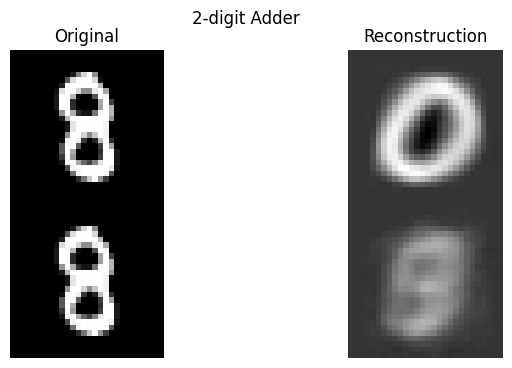

In [ ]:
# RUN THIS CELL WITH DIRECTORY 'TEST3' LOADED (ETA <1sec)

with open(os.path.join('test3', 'aec_preds.pkl'), 'rb') as f:
    rec_imgs = pickle.load(f)
with open(os.path.join('test3', 'aec_labels.pkl'), 'rb') as f:
    y_pred = pickle.load(f)

GUI_display(
    x_test.reshape((-1, 28 + 28, 28)),
    rec_imgs.reshape((-1, 28 + 28, 28)),
    y_test,
    y_pred,
    '2-digit Adder'
)

We can immediately see that this is a much more difficult problem for the autoencoder to solve. It scarcely gives a comparatively clear and correct output at the same time. the MSD part is often a blur between 0 and 1, making it hard to distinguish what the coder actually thinks the sum should be. The LSD is an even worse case; it only barely becomes clear enough when it represents a 3.

##**Test #4: Denoising**

Lastly, let's see a more practical use of Autoencoders in action; denoising. Noise-errors are of the most common problems met, as they can happen in multiple ways.

An autoencoder attempts denoising by mapping the noisy image to the original one and trying to identify which components are mistakes. There is no dimensionality reduction here, so typically the bottleneck is of the same size as the input.

To simulate noise, we will need yet another aid-function, that sprinkles random numbers from a gaussian distribution onto the image.

In [ ]:
def add_noise(x: np.ndarray, mean: float=0.0, std: float=25.0):
    ''' Adds gaussian noise to the passed images. Control mean
        and std for different noise intensity and density.
    '''
    noisy_x = x.copy()
    for i in range(len(noisy_x)):
        noise = np.random.normal(mean, std, noisy_x[i].shape)
        noisy_x[i] = np.clip(noisy_x[i] + noise, 0, 255).astype(np.uint8)
    return noisy_x

I went kind of overboard with the density of the noise; most sources on the internet recommended a standard deviation of around 25 for more realistic results. However, I wanted to see how capable this machine is.

In [ ]:
DIM = 28 * 28

(x_target, y_train), (x_test, y_test) = mnist.load_data()

x_target, y_train = x_target.reshape(-1, DIM), y_train.reshape(-1, 1)
x_test, y_test = x_test.reshape(-1, DIM), y_test.reshape(-1, 1)

# create inputs by noising the corresponding 'correct' images
x_train = add_noise(x_target, std=50)
x_test = add_noise(x_test, std=50)

In [ ]:
aec3 = Autoencoder(dim=DIM).fit(x_train, x_target, y_train)

rec_imgs = aec3.reconstruct(x_test).reshape((-1, 28, 28))
y_pred = aec3.oracle.predict(rec_imgs.reshape(-1, DIM)).reshape(-1, 1)

# PICKLE-ING THE RESULTS SO YOU DONT HAVE TO RERUN THIS CELL
with open(os.path.join('test4', 'aec_preds.pkl'), 'wb') as f:
    pickle.dump(rec_imgs, f)
with open(os.path.join('test4', 'aec_labels.pkl'), 'wb') as f:
    pickle.dump(y_pred, f)

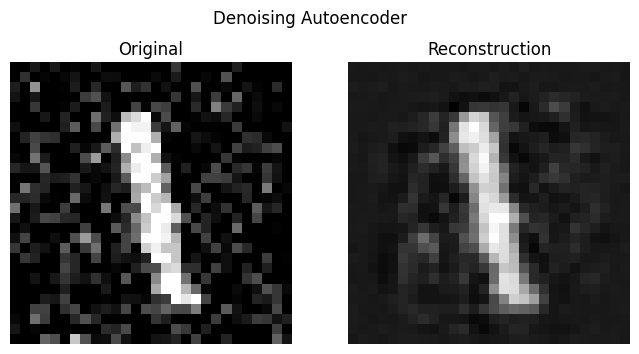

In [ ]:
# RUN THIS CELL WITH THE DIRECTORY 'TEST4' LOADED (ETA <1sec)

org_imgs = x_test.reshape((-1, 28, 28))

with open(os.path.join('test4', 'aec_preds.pkl'), 'rb') as f:
    rec_imgs = pickle.load(f)
with open(os.path.join('test4', 'aec_labels.pkl'), 'rb') as f:
    y_pred = pickle.load(f)

GUI_display(org_imgs, rec_imgs, y_test, y_pred, 'Denoising Autoencoder')

The intensity of the noise more or less subsides. The digit shape remains bright and clearly visible, which is the most important part anyway. It's interesting that the model wipes the noise almost completely off the edges of the image, but is more reluctant as it approaches the digit. While the noise left is tame in comparison with the input, it is still very much visible and it implies that the model deems the integrity of the digit shape more important than that of the background, which is what we would hope.